<a href="https://colab.research.google.com/github/huggingface/transformers/blob/update_notebook/notebooks/05_benchmark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **How to benchmark models with Transformers**

With ever-larger language models, it is no longer enough to just 
compare models on their performance on a specific task. One should always be aware of the computational cost that is attached to a specific model. For a given computation environment (*e.g.* type of GPU), the computational cost of training a model or deploying it in inference usually depends only on **the required memory** and **the required time**. 

Being able to accurately benchmark language models on both *speed* and *required memory* is therefore very important.

HuggingFace's Transformer library allows users to benchmark models for both TensorFlow 2 and PyTorch using the `PyTorchBenchmark` and `TensorFlowBenchmark` classes.

The currently available features for `PyTorchBenchmark` are summarized in the following table.


| | CPU | CPU + torchscript | GPU | GPU + torchscript | GPU + FP16 | TPU |
:-- | :--- | :--- | :--- | :--- | :--- | :--- |
**Speed - Inference** | ✔ | ✔ | ✔ | ✔ | ✔ | ✔ |
**Memory - Inference** | ✔ | ✔ | ✔ | ✔ | ✔ | ✘ |
**Speed - Train** | ✔ | ✘ | ✔ | ✘ | ✔ | ✔ |
**Memory - Train** | ✔ | ✘ | ✔ | ✘ | ✔ | ✘ |


*   *FP16* stands for mixed-precision meaning that computations within the model are done using a mixture of 16-bit and 32-bit floating-point operations, see [here](https://pytorch.org/docs/stable/nn.html#torch.nn.Module.half) for more detail.

*   *torchscript* corresponds to PyTorch's torchscript format, see [here](https://pytorch.org/docs/stable/jit.html).

The currently available features for `TensorFlowBenchmark` are summarized in the following table.

| | CPU | CPU + eager execution | GPU | GPU + eager execution | GPU + XLA | GPU + FP16 | TPU |
:-- | :--- | :--- | :--- | :--- | :--- | :--- | :--- |
**Speed - Inference** | ✔ | ✔ | ✔ | ✔ | ✔ | ✘ | ✔ |
**Memory - Inference** | ✔ | ✔ | ✔ | ✔ | ✔ | ✘ | ✘ |
**Speed - Train** | ✔ | ✘ | ✔ | ✘ | ✘ | ✘ | ✔ |
**Memory - Train** | ✔ | ✘ | ✔ | ✘ | ✘ | ✘ | ✘ |

*   *eager execution* means that the function is run in the eager execution environment of TensorFlow 2, see [here](https://www.tensorflow.org/guide/eager).

*   *XLA* stands for TensorFlow's Accelerated Linear Algebra (XLA) compiler, see [here](https://www.tensorflow.org/xla)

*   *FP16* stands for TensorFlow's mixed-precision package and is analogous to PyTorch's FP16 feature, see [here](https://www.tensorflow.org/guide/mixed_precision).

***Note***: Benchmark training in TensorFlow is not included in v3.0.2, but available in master.


This notebook will show the user how to use `PyTorchBenchmark` and `TensorFlowBenchmark` for two different scenarios:

1. **Inference - Pre-trained Model Comparison** - *A user wants to implement a pre-trained model in production for inference. She wants to compare different models on speed and required memory.*

2. **Training - Configuration Comparison** - *A user wants to train a specific model and searches that for himself most effective model configuration.*


### **Inference - Pre-trained Model Comparison**

Let's say we want to employ a question-answering model in production. The questions are expected to be of the same format as in **SQuAD v2**, so that the model to choose should have been fine-tuned on this dataset. 

HuggingFace's new dataset [webpage](https://huggingface.co/datasets) lets the user see all relevant information about a dataset and even links the models that have been fine-tuned on this specific dataset. Let's check out the dataset webpage of SQuAD v2 [here](https://huggingface.co/datasets/squad_v2).

Nice, we can see that there are 7 available models.

![Texte alternatif…](https://raw.githubusercontent.com/patrickvonplaten/scientific_images/master/squad_v2_dataset.png)

Let's assume that we have decided to restrict our pipeline to "encoder-only" models so that we are left with:

- `a-ware/roberta-large-squad-classification`
- `a-ware/xlmroberta-squadv2`
- `aodiniz/bert_uncased_L-10_H-512_A-8_cord19-200616_squad2`
- `deepset/roberta-base-squad2`
- `mrm8488/longformer-base-4096-finetuned-squadv2`

Great! In this notebook, we will now benchmark these models on both peak memory consumption and inference time to decide which model should be employed in production.

***Note***: None of the models has been tested on performance so that we will just assume that all models perform more or less equally well. The purpose of this notebook is not to find the best model for SQuAD v2, but to showcase how Transformers benchmarking tools can be leveraged.

First, we assume to be limited by the available GPU on this google colab, which in this copy amounts to 16 GB of RAM.

In a first step, we will check which models are the most memory-efficient ones.
Let's make sure 100% of the GPU is available to us in this notebook.

In [ ]:
#@title Check available memory of GPU
# Check that we are using 100% of GPU
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip -q install gputil
!pip -q install psutil
!pip -q install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Gen RAM Free: 12.8 GB  | Proc size: 160.0 MB
GPU RAM Free: 16280MB | Used: 0MB | Util   0% | Total 16280MB


In [ ]:
# If GPU RAM Util > 0% => crash notebook on purpose
# !kill -9 -1

Looks good! Now we import `transformers` and download the scripts `run_benchmark.py`, `run_benchmark_tf.py`, and `plot_csv_file.py` which can be found under `transformers/examples/benchmarking`.

`run_benchmark_tf.py` and `run_benchmark.py` are very simple scripts leveraging the `PyTorchBenchmark` and `TensorFlowBenchmark` classes, respectively.

In [ ]:
# install transformes
!pip uninstall -y transformers
!pip install -q git+https://github.com/huggingface/transformers.git

# install py3nvml to track GPU memory usage
!pip install -q py3nvml

!rm -f run_benchmark.py
!rm -f run_benchmark_tf.py
!rm -f plot_csv_file.py
!wget https://raw.githubusercontent.com/huggingface/transformers/master/examples/benchmarking/run_benchmark.py -qq
!wget https://raw.githubusercontent.com/huggingface/transformers/master/examples/benchmarking/run_benchmark_tf.py -qq
!wget https://raw.githubusercontent.com/huggingface/transformers/master/examples/benchmarking/plot_csv_file.py -qq

# import pandas to pretty print csv files
import pandas as pd

Information about the input arguments to the *run_benchmark* scripts can be accessed by running `!python run_benchmark.py --help` for PyTorch and `!python run_benchmark_tf.py --help` for TensorFlow.

In [ ]:
!python run_benchmark.py --help

2020-06-26 11:51:47.129203: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
usage: run_benchmark.py [-h] [--models MODELS [MODELS ...]]
                        [--batch_sizes BATCH_SIZES [BATCH_SIZES ...]]
                        [--sequence_lengths SEQUENCE_LENGTHS [SEQUENCE_LENGTHS ...]]
                        [--no_inference] [--no_cuda] [--no_tpu] [--fp16]
                        [--training] [--verbose] [--no_speed] [--no_memory]
                        [--trace_memory_line_by_line] [--save_to_csv]
                        [--log_print] [--no_env_print] [--no_multi_process]
                        [--with_lm_head]
                        [--inference_time_csv_file INFERENCE_TIME_CSV_FILE]
                        [--inference_memory_csv_file INFERENCE_MEMORY_CSV_FILE]
                        [--train_time_csv_file TRAIN_TIME_CSV_FILE]
                        [--train_memory_csv_file TRAIN_MEMORY_CSV_FILE]
       

Great, we are ready to run our first memory benchmark. By default, both the *required memory* and *time* for inference is enabled. To disable benchmarking on *time*, we add `--no_speed`.

The only required parameter is `--models` which expects a list of model identifiers as defined on the [model hub](https://huggingface.co/models). Here we add the five model identifiers listed above.

Next, we define the `sequence_lengths` and `batch_sizes` for which the peak memory is calculated.

Finally, because the results should be stored in a *CSV* file, the option `--save_to_csv` is added and the path to save the results is added via the `--inference_memory_csv_file` argument. 
Whenever a benchmark is run, the environment information, *e.g.* GPU type, library versions, ... can be saved using the `--env_info_csv_file` argument.

In [ ]:
# create plots folder in content
!mkdir -p plots_pt

In [ ]:
# run benchmark
!python run_benchmark.py --no_speed --save_to_csv \
                                --models a-ware/roberta-large-squad-classification \
                                  a-ware/xlmroberta-squadv2 \
                                  aodiniz/bert_uncased_L-10_H-512_A-8_cord19-200616_squad2 \
                                  deepset/roberta-base-squad2 \
                                  mrm8488/longformer-base-4096-finetuned-squadv2 \
                                --sequence_lengths 32 128 512 1024 \
                                --batch_sizes 32 \
                                --inference_memory_csv_file plots_pt/required_memory.csv \
                                --env_info_csv_file plots_pt/env.csv >/dev/null 2>&1  # redirect all prints

Under `plots_pt`, two files are now created: `required_memory.csv` and `env.csv`. Let's check out `required_memory.csv` first.

In [ ]:
df = pd.read_csv('plots_pt/required_memory.csv')
df

,model,batch_size,sequence_length,result
0,a-ware/roberta-large-squad-classification,32,32,2219.0
1,a-ware/roberta-large-squad-classification,32,128,2455.0
2,a-ware/roberta-large-squad-classification,32,512,3641.0
3,a-ware/roberta-large-squad-classification,32,1024,NaN
4,a-ware/xlmroberta-squadv2,32,32,2999.0
5,a-ware/xlmroberta-squadv2,32,128,3235.0
6,a-ware/xlmroberta-squadv2,32,512,4421.0
7,a-ware/xlmroberta-squadv2,32,1024,NaN
8,aodiniz/bert_uncased_L-10_H-512_A-8_cord19-200...,32,32,1025.0
9,aodiniz/bert_uncased_L-10_H-512_A-8_cord19-200...,32,128,1143.0


Each row in the csv file lists one data point showing the *peak memory* usage for a given model, batch_size and sequence_length. As can be seen, some values have a *NaN* result meaning that an *Out-of-Memory* Error occurred. To better visualize the results, one can make use of the `plot_csv_file.py` script.

Before, let's take a look at the information about our computation environment.

In [ ]:
df = pd.read_csv('plots_pt/env.csv')
df

,transformers_version,2.11.0
0,framework,PyTorch
1,use_torchscript,False
2,framework_version,1.5.1+cu101
3,python_version,3.6.9
4,system,Linux
5,cpu,x86_64
6,architecture,64bit
7,date,2020-06-26
8,time,11:56:37.277009
9,fp16,False


We can see all relevant information here: the PyTorch version, the Python version, the system, the type of GPU, and available RAM on the GPU, etc...

**Note**: A different GPU is likely assigned to a copy of this notebook, so that all of the following results may be different. It is very important to always include the environment information when benchmarking your models for both reproducibility and transparency to other users.

Alright, let's plot the results.

2020-06-26 11:56:39.671579: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1


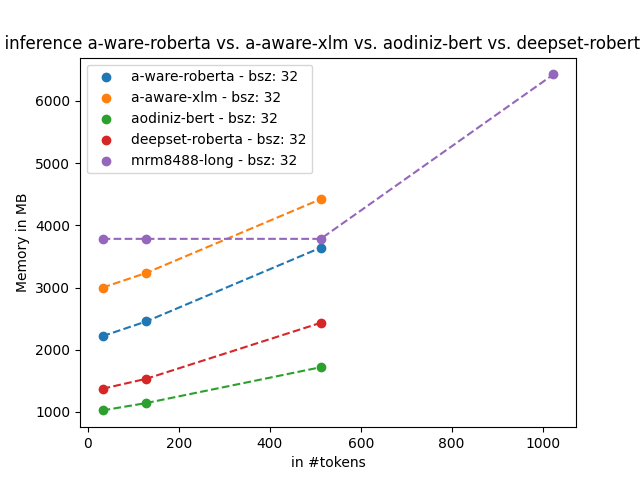

In [ ]:
# plot graph and save as image
!python plot_csv_file.py --csv_file plots_pt/required_memory.csv --figure_png_file=plots_pt/required_memory_plot.png --no_log_scale --short_model_names a-ware-roberta a-aware-xlm aodiniz-bert deepset-roberta mrm8488-long

# show image
from IPython.display import Image
Image('plots_pt/required_memory_plot.png')

At this point, it is important to understand how the peak memory is measured. The benchmarking tools measure the peak memory usage the same way the command `nvidia-smi` does - see [here](https://developer.nvidia.com/nvidia-system-management-interface) for more information. 
In short, all memory that is allocated for a given *model identifier*, *batch size* and *sequence length* is measured in a separate process. This way it can be ensured that there is no previously unreleased memory falsely included in the measurement. One should also note that the measured memory even includes the memory allocated by the CUDA driver to load PyTorch and TensorFlow and is, therefore, higher than library-specific memory measurement function, *e.g.* this one for [PyTorch](https://pytorch.org/docs/stable/cuda.html#torch.cuda.max_memory_allocated).

Alright, let's analyze the results. It can be noted that the models `aodiniz/bert_uncased_L-10_H-512_A-8_cord19-200616_squad2` and `deepset/roberta-base-squad2` require significantly less memory than the other three models. Besides `mrm8488/longformer-base-4096-finetuned-squadv2` all models more or less follow the same memory consumption pattern with `aodiniz/bert_uncased_L-10_H-512_A-8_cord19-200616_squad2` seemingly being able to better scale to larger sequence lengths. 
`mrm8488/longformer-base-4096-finetuned-squadv2` is a *Longformer* model, which makes use of *LocalAttention* (check [this](https://huggingface.co/blog/reformer) blog post to learn more about local attention) so that the model scales much better to longer input sequences.

For the sake of this notebook, we assume that the longest required input will be less than 512 tokens so that we settle on the models `aodiniz/bert_uncased_L-10_H-512_A-8_cord19-200616_squad2` and `deepset/roberta-base-squad2`. 

To better understand how many API requests of our *question-answering* pipeline can be run in parallel, we are interested in finding out how many batches the two models run out of memory.

In [ ]:
!python run_benchmark.py --no_speed --save_to_csv \
                                --inference_memory_csv_file plots_pt/required_memory_2.csv \
                                --env_info_csv_file plots_pt/env.csv \
                                --models aodiniz/bert_uncased_L-10_H-512_A-8_cord19-200616_squad2 \
                                  deepset/roberta-base-squad2 \
                                --sequence_lengths 512 \
                                --batch_sizes 64 128 256 512\
                                --no_env_print

2020-06-26 11:56:44.781155: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
1 / 2
2 / 2
Doesn't fit on GPU. CUDA out of memory. Tried to allocate 6.00 GiB (GPU 0; 15.90 GiB total capacity; 9.47 GiB already allocated; 5.60 GiB free; 9.52 GiB reserved in total by PyTorch)

====================      INFERENCE - MEMORY - RESULT       ====================
--------------------------------------------------------------------------------
          Model Name             Batch Size     Seq Length    Memory in MB 
--------------------------------------------------------------------------------
aodiniz/bert_uncased_L-10_H-51       64             512             2455     
aodiniz/bert_uncased_L-10_H-51      128             512             3929     
aodiniz/bert_uncased_L-10_H-51      256             512             6875     
aodiniz/bert_uncased_L-10_H-51      512             512            12783     
 deepset/roberta-base-squad

Let's plot the results again, this time changing the x-axis to `batch_size` however.

2020-06-26 11:57:51.876810: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1


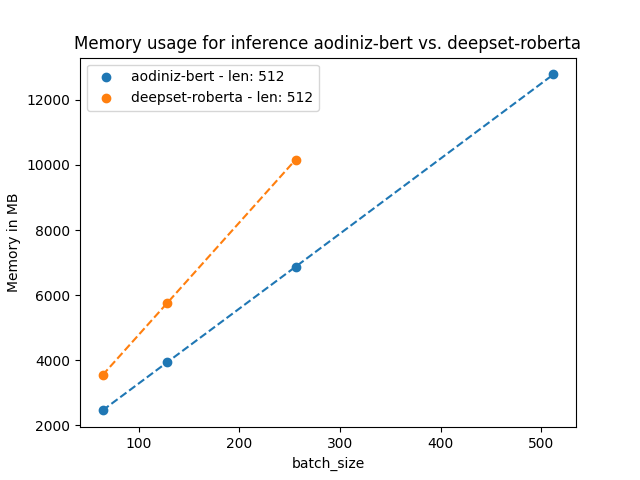

In [ ]:
# plot graph and save as image
!python plot_csv_file.py --csv_file plots_pt/required_memory_2.csv \
                          --figure_png_file=plots_pt/required_memory_plot_2.png \
                          --no_log_scale \
                          --short_model_names aodiniz-bert deepset-roberta \
                          --plot_along_batch

# show image
from IPython.display import Image
Image('plots_pt/required_memory_plot_2.png')

Interesting! `aodiniz/bert_uncased_L-10_H-51` clearly scales better for higher batch sizes and does not even run out of memory for 512 tokens.

For comparison, let's run the same benchmarking on TensorFlow.

In [ ]:
# create plots folder in content
!mkdir -p plots_tf

!TF_CPP_MIN_LOG_LEVEL=3 python run_benchmark_tf.py --no_speed --save_to_csv \
                                --inference_memory_csv_file plots_tf/required_memory_2.csv \
                                --env_info_csv_file plots_tf/env.csv \
                                --models aodiniz/bert_uncased_L-10_H-512_A-8_cord19-200616_squad2 \
                                         deepset/roberta-base-squad2 \
                                --sequence_lengths 512 \
                                --batch_sizes 64 128 256 512 \
                                --no_env_print \

1 / 2
Doesn't fit on GPU.  OOM when allocating tensor with shape[512,8,512,512] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node tf_bert_model/bert/encoder/layer_._0/attention/self/Softmax (defined at /usr/local/lib/python3.6/dist-packages/transformers/modeling_tf_bert.py:267) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_run_in_graph_mode_4243]

Errors may have originated from an input operation.
Input Source operations connected to node tf_bert_model/bert/encoder/layer_._0/attention/self/Softmax:
 tf_bert_model/bert/encoder/layer_._0/attention/self/add (defined at /usr/local/lib/python3.6/dist-packages/transformers/modeling_tf_bert.py:264)

Function call stack:
run_in_graph_mode

2 / 2
Doesn't fit on GPU.  OOM when allocating tensor with shape[512,12,512,512] and type float on /job:localhost/replica:0/task:0/devic

Let's see the same plot for TensorFlow.

2020-06-26 11:59:28.790462: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1


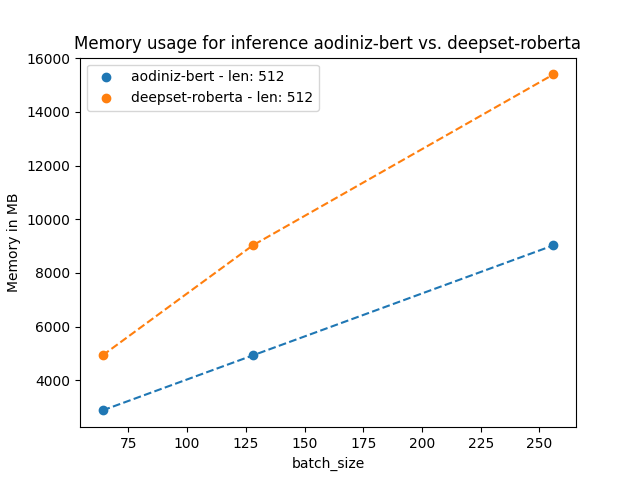

In [ ]:
# plot graph and save as image
!python plot_csv_file.py --csv_file plots_tf/required_memory_2.csv --figure_png_file=plots_tf/required_memory_plot_2.png --no_log_scale --short_model_names aodiniz-bert deepset-roberta --plot_along_batch

# show image
from IPython.display import Image
Image('plots_tf/required_memory_plot_2.png')

The model implemented in TensorFlow requires more memory than the one implemented in PyTorch. Let's say for whatever reason we have decided to use TensorFlow instead of PyTorch. 

The next step is to measure the inference time of these two models. Instead of disabling time measurement with `--no_speed`, we will now disable memory measurement with `--no_memory`.

In [ ]:
!TF_CPP_MIN_LOG_LEVEL=3 python run_benchmark_tf.py --no_memory --save_to_csv \
                                --inference_time_csv_file plots_tf/time_2.csv \
                                --env_info_csv_file plots_tf/env.csv \
                                --models aodiniz/bert_uncased_L-10_H-512_A-8_cord19-200616_squad2 \
                                         deepset/roberta-base-squad2 \
                                --sequence_lengths 8 32 128 512 \
                                --batch_sizes 256 \
                                --no_env_print \

1 / 2
2 / 2

====================       INFERENCE - SPEED - RESULT       ====================
--------------------------------------------------------------------------------
          Model Name             Batch Size     Seq Length     Time in s   
--------------------------------------------------------------------------------
aodiniz/bert_uncased_L-10_H-51      256              8             0.033     
aodiniz/bert_uncased_L-10_H-51      256              32            0.119     
aodiniz/bert_uncased_L-10_H-51      256             128            0.457     
aodiniz/bert_uncased_L-10_H-51      256             512             2.21     
 deepset/roberta-base-squad2        256              8             0.064     
 deepset/roberta-base-squad2        256              32             0.25     
 deepset/roberta-base-squad2        256             128             1.01     
 deepset/roberta-base-squad2        256             512             4.65     
--------------------------------------------

2020-06-26 12:04:58.002654: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1


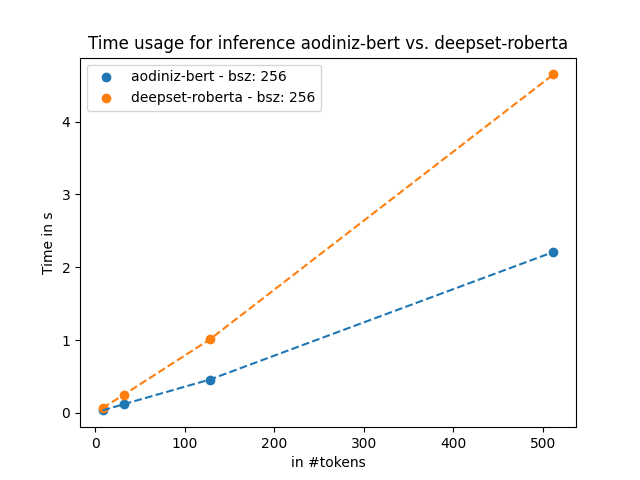

In [ ]:
# plot graph and save as image
!python plot_csv_file.py --csv_file plots_tf/time_2.csv --figure_png_file=plots_tf/time_plot_2.png --no_log_scale --short_model_names aodiniz-bert deepset-roberta --is_time

# show image
from IPython.display import Image
Image('plots_tf/time_plot_2.png')

Ok, this took some time... time measurements take much longer than memory measurements because the forward pass is called multiple times for stable results. Timing measurements leverage Python's [timeit module](https://docs.python.org/2/library/timeit.html#timeit.Timer.repeat) and run 10 times the value given to the `--repeat` argument (defaults to 3), so in our case 30 times.

Let's focus on the resulting plot. It becomes obvious that `aodiniz/bert_uncased_L-10_H-51` is around twice as fast as `deepset/roberta-base-squad2`. Given that the model is also more memory efficient and assuming that the model performs reasonably well, for the sake of this notebook we will settle on `aodiniz/bert_uncased_L-10_H-51`. Our model should be able to process input sequences of up to 512 tokens. Latency time of around 2 seconds might be too long though, so let's compare the time for different batch sizes and using TensorFlows XLA package for more speed.

In [ ]:
!TF_CPP_MIN_LOG_LEVEL=3 python run_benchmark_tf.py --no_memory --save_to_csv \
                                --inference_time_csv_file plots_tf/time_xla_1.csv \
                                --env_info_csv_file plots_tf/env.csv \
                                --models aodiniz/bert_uncased_L-10_H-512_A-8_cord19-200616_squad2 \
                                --sequence_lengths 512 \
                                --batch_sizes 8 64 256 \
                                --no_env_print \
                                --use_xla

1 / 1

====================       INFERENCE - SPEED - RESULT       ====================
--------------------------------------------------------------------------------
          Model Name             Batch Size     Seq Length     Time in s   
--------------------------------------------------------------------------------
aodiniz/bert_uncased_L-10_H-51       8              512            0.056     
aodiniz/bert_uncased_L-10_H-51       64             512            0.402     
aodiniz/bert_uncased_L-10_H-51      256             512            1.591     
--------------------------------------------------------------------------------
Saving results to csv.


First of all, it can be noted that XLA reduces latency time by a factor of ca. 1.3 (which is more than observed for other models by TensorFlow [here](https://www.tensorflow.org/xla)). A batch size of 64 looks like a good choice. More or less half a second for the forward pass is good enough.

Cool, now it should be straightforward to benchmark your favorite models. All the inference time measurements can also be done using the `run_benchmark.py` script for PyTorch.

### **Training - Configuration Comparison**

Next, we will look at how a model can be benchmarked on different configurations. This is especially helpful when one wants to decide how to most efficiently choose the model's configuration parameters for training.
In the following different configurations of a *Bart MNLI* model will be compared to each other using `PyTorchBenchmark`. 

Training in `PyTorchBenchmark` is defined by running one forward pass to compute the loss: `loss = model(input_ids, labels=labels)[0]` and one backward pass to compute the gradients `loss.backward()`.

Let's see how to most efficiently train a Bart MNLI model from scratch.

In [ ]:
# Imports
from transformers import BartConfig, PyTorchBenchmark, PyTorchBenchmarkArguments

For the sake of the notebook, we assume that we are looking for a more efficient version of Facebook's `bart-large-mnli` model.
Let's load its configuration and check out the important parameters.

In [ ]:
BartConfig.from_pretrained("facebook/bart-large-mnli").to_diff_dict()

{'_num_labels': 3,
 'activation_dropout': 0.0,
 'activation_function': 'gelu',
 'add_bias_logits': False,
 'add_final_layer_norm': False,
 'attention_dropout': 0.0,
 'bos_token_id': 0,
 'classifier_dropout': 0.0,
 'd_model': 1024,
 'decoder_attention_heads': 16,
 'decoder_ffn_dim': 4096,
 'decoder_layerdrop': 0.0,
 'decoder_layers': 12,
 'dropout': 0.1,
 'encoder_attention_heads': 16,
 'encoder_ffn_dim': 4096,
 'encoder_layerdrop': 0.0,
 'encoder_layers': 12,
 'eos_token_id': 2,
 'extra_pos_embeddings': 2,
 'id2label': {0: 'contradiction', 1: 'neutral', 2: 'entailment'},
 'init_std': 0.02,
 'is_encoder_decoder': True,
 'label2id': {'contradiction': 0, 'entailment': 2, 'neutral': 1},
 'max_position_embeddings': 1024,
 'model_type': 'bart',
 'normalize_before': False,
 'normalize_embedding': True,
 'num_hidden_layers': 12,
 'output_past': False,
 'pad_token_id': 1,
 'scale_embedding': False,
 'static_position_embeddings': False,
 'vocab_size': 50265}

Alright! The important configuration parameters are usually the number of layers `config.encoder_num_layers` and `config.decoder_num_layers`, the model's hidden size: `config.d_model`, the number of attention heads `config.encoder_attention_heads` and `config.decoder_attention_heads` and the vocabulary size `config.vocab_size`.

Let's create 4 configurations different from the baseline and see how they compare in terms of peak memory consumption.

In [ ]:
config_baseline = BartConfig.from_pretrained("facebook/bart-large-mnli")
config_768_hidden = BartConfig.from_pretrained("facebook/bart-large-mnli", d_model=768)
config_8_heads = BartConfig.from_pretrained("facebook/bart-large-mnli", decoder_attention_heads=8, encoder_attention_heads=8)
config_10000_vocab = BartConfig.from_pretrained("facebook/bart-large-mnli", vocab_size=10000)
config_8_layers = BartConfig.from_pretrained("facebook/bart-large-mnli", encoder_layers=8, decoder_layers=8)

Cool, now we can benchmark these configs against the baseline config. This time, instead of using the benchmarking script we will directly use the `PyTorchBenchmark` class. The class expects the argument `args` which has to be of type `PyTorchBenchmarkArguments` and optionally a list of configs.

First, we define the `args` and give the different configurations appropriate model names. The model names must be in the same order as the configs that are directly passed to `PyTorchBenchMark`.

If no `configs` are provided to `PyTorchBenchmark`, it is assumed that the model names `["bart-base", "bart-768-hid", "bart-8-head", "bart-10000-voc", "bart-8-lay"]` correspond to official model identifiers and their corresponding configs are loaded as was shown in the previous section.

It is assumed that the model will be trained on half-precision, so we add the option `fp16=True` for the following benchmarks.

In [ ]:
# define args
args = PyTorchBenchmarkArguments(models=["bart-base", "bart-768-hid", "bart-8-head", "bart-10000-voc", "bart-8-lay"], 
                                 no_speed=True,
                                 no_inference=True,
                                 training=True, 
                                 train_memory_csv_file="plots_pt/training_mem_fp16.csv", 
                                 save_to_csv=True, 
                                 env_info_csv_file="plots_pt/env.csv",
                                 sequence_lengths=[64, 128, 256, 512],
                                 batch_sizes=[8],
                                 no_env_print=True,
                                 fp16=True)  # let's train on fp16

# create benchmark
benchmark = PyTorchBenchmark(configs=[config_baseline, config_768_hidden, config_8_heads, config_10000_vocab, config_8_layers], args=args)

# run benchmark
result = benchmark.run()

1 / 5
2 / 5
3 / 5
4 / 5
5 / 5

====================        TRAIN - MEMORY - RESULTS        ====================
--------------------------------------------------------------------------------
          Model Name             Batch Size     Seq Length    Memory in MB 
--------------------------------------------------------------------------------
          bart-base                  8               64             2905     
          bart-base                  8              128             3199     
          bart-base                  8              256             5401     
          bart-base                  8              512            11929     
         bart-768-hid                8               64             2441     
         bart-768-hid                8              128             2891     
         bart-768-hid                8              256             4963     
         bart-768-hid                8              512            10865     
         bart-8-head      

Nice, let's plot the results again.

2020-06-26 12:11:47.558303: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1


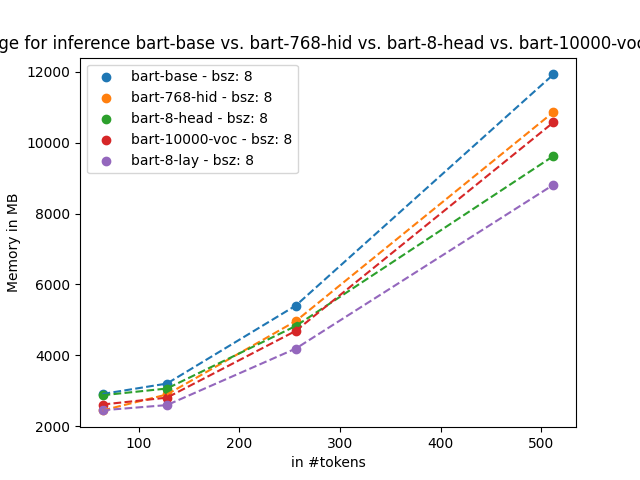

In [ ]:
# plot graph and save as image
!python plot_csv_file.py --csv_file plots_pt/training_mem_fp16.csv --figure_png_file=plots_pt/training_mem_fp16.png --no_log_scale

# show image
from IPython.display import Image
Image('plots_pt/training_mem_fp16.png')

As expected the model of the baseline config requires the most memory. 

It is interesting to see that the "bart-8-head" model initially requires more memory than `bart-10000-voc`, but then clearly outperforms `bart-10000-voc` at an input length of 512. 
Less surprising is that the "bart-8-lay" is by far the most memory-efficient model when reminding oneself that during the forward pass every layer has to store its activations for the backward pass.

Alright, given the data above, let's say we narrow our candidates down to only the "bart-8-head" and "bart-8-lay" models. 
 
Let's compare these models again on training time.

In [ ]:
# define args
args = PyTorchBenchmarkArguments(models=["bart-8-head", "bart-8-lay"], 
                                 no_inference=True,
                                 training=True,
                                 no_memory=True,
                                 train_time_csv_file="plots_pt/training_speed_fp16.csv", 
                                 save_to_csv=True, 
                                 env_info_csv_file="plots_pt/env.csv",
                                 sequence_lengths=[32, 128, 512],
                                 batch_sizes=[8],
                                 no_env_print=True,
                                 repeat=1, # to make speed measurement faster but less accurate
                                 no_multi_process=True,  # google colab has problems with multi processing
                                 fp16=True
                                 )

# create benchmark
benchmark = PyTorchBenchmark(configs=[config_8_heads, config_8_layers], args=args)

# run benchmark
result = benchmark.run()

1 / 2
2 / 2

====================        TRAIN - SPEED - RESULTS         ====================
--------------------------------------------------------------------------------
          Model Name             Batch Size     Seq Length     Time in s   
--------------------------------------------------------------------------------
         bart-8-head                 8               32            0.127     
         bart-8-head                 8              128            0.398     
         bart-8-head                 8              512            1.567     
          bart-8-lay                 8               32            0.088     
          bart-8-lay                 8              128            0.284     
          bart-8-lay                 8              512            1.153     
--------------------------------------------------------------------------------
Saving results to csv.


The option `no_multi_process` disabled multi-processing here. This option should in general only be used for testing or debugging. Enabling multi-processing is crucial to ensure accurate memory consumption measurement, but is less important when only measuring speed. The main reason it is disabled here is that google colab sometimes raises "CUDA initialization" due to the notebook's environment. 
This problem does not arise when running benchmarks outside of a notebook.

Alright, let's plot the last speed results as well.

2020-06-26 12:13:17.849561: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1


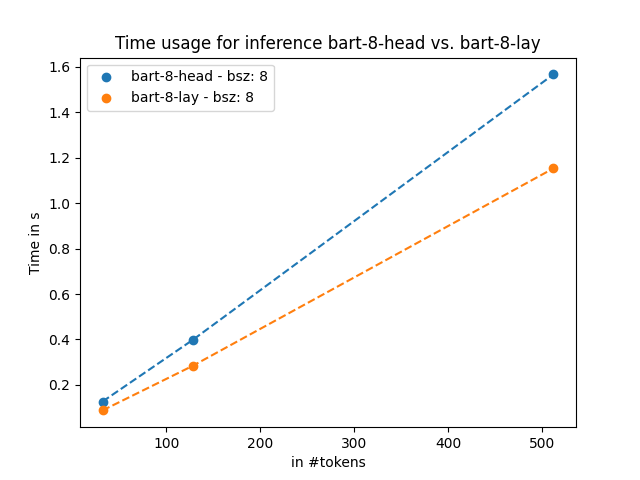

In [ ]:
# plot graph and save as image
!python plot_csv_file.py --csv_file plots_pt/training_speed_fp16.csv --figure_png_file=plots_pt/training_speed_fp16.png --no_log_scale --is_time

# show image
from IPython.display import Image
Image('plots_pt/training_speed_fp16.png')

Unsurprisingly, "bart-8-lay" is faster than "bart-8-head" by a factor of ca. 1.3. It might very well be that reducing the layers by a factor of 2 leads to much more performance degradation than reducing the number of heads by a factor of 2.
For more information on computational efficient Bart models, check out the new *distilbart* model [here](https://huggingface.co/models?search=distilbart)

Alright, that's it! Now you should be able to benchmark your favorite models on your favorite configurations. 

Feel free to share your results with the community [here](https://github.com/huggingface/transformers/blob/master/examples/benchmarking/README.md) or by tweeting us https://twitter.com/HuggingFace 🤗.